In [1]:
import itertools
import numpy as np
from photon_canon import Medium, System, Illumination, Detector
from photon_canon.hardware import create_oblique_beams, create_cone_of_acceptance
import multiprocessing as mp
import matplotlib.pyplot as plt
from photon_canon.lut import generate_lut, LUT
from photon_canon.contrib.diffusion_theory import create_integrated_diffusion_approximation
mp.set_start_method('spawn', force=True)

C:\Users\jdivers\AppData\Local\miniconda3\envs\photon_canon\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define parameter for simulation
g = 0.9
d = 0.2  # 2 mm
n = 50000
recurse = False
wl0 = 650

# Variable parameters
mu_s_prime_array = np.arange(0, 50.5, 0.5)
mu_s_array = mu_s_prime_array / (1 - g)
mu_a_array = np.arange(0.5, 51, 0.5)

# Make water medium
di_water = Medium(n=1.33, mu_s=0, mu_a=0, g=0, desc='di water')
glass = Medium(n=1.523, mu_s=0, mu_a=0, g=0, desc='glass')

# Create an illuminator
lamp = Illumination(create_oblique_beams((0, 1), 60, 1.5))

# Create detection cone
detector = Detector(create_cone_of_acceptance(r=1.8, na=1, n=1.33))

# Start the system
system = System(di_water, 0.2,  # 1mm
                glass, 0.017,  # 0.17mm
                surrounding_n=1.33,
                illuminator=lamp,
                detector=(detector, 0)
                )
variable = Medium(n=1.33, mu_s=10, mu_a=0.1, g=0.8, desc='tissue')  # Placeholder to update at iteration
system.add(variable, d)

C:\Users\jdivers\PycharmProjects\photon_canon\src\photon_canon\optics.py:48: UserWarning: g is automatically set to 1 where mu_s is 0. Set a non-zero scattering coefficient if a non-unity g value is necessary.
  warnings.warn('g is automatically set to 1 where mu_s is 0. '


# Generate a new LUT

In [4]:
# Generate a photon object (either directly or through the system illumination)
photon = system.beam(batch_size=n, recurse=recurse)
simulation_id = generate_lut(system, 
                             variable, 
                             {'mu_s': mu_s_array, 'mu_a': mu_a_array, 'g': g_array}, 
                             photon,
                             pbar=True,
                             num_workers=15)

Sim ID: 88: 100%|██████████| 10201/10201 [7:52:31<00:00,  2.78s/it]  


# Show the newly generated LUT and compare to diffusion approximation for validation

88


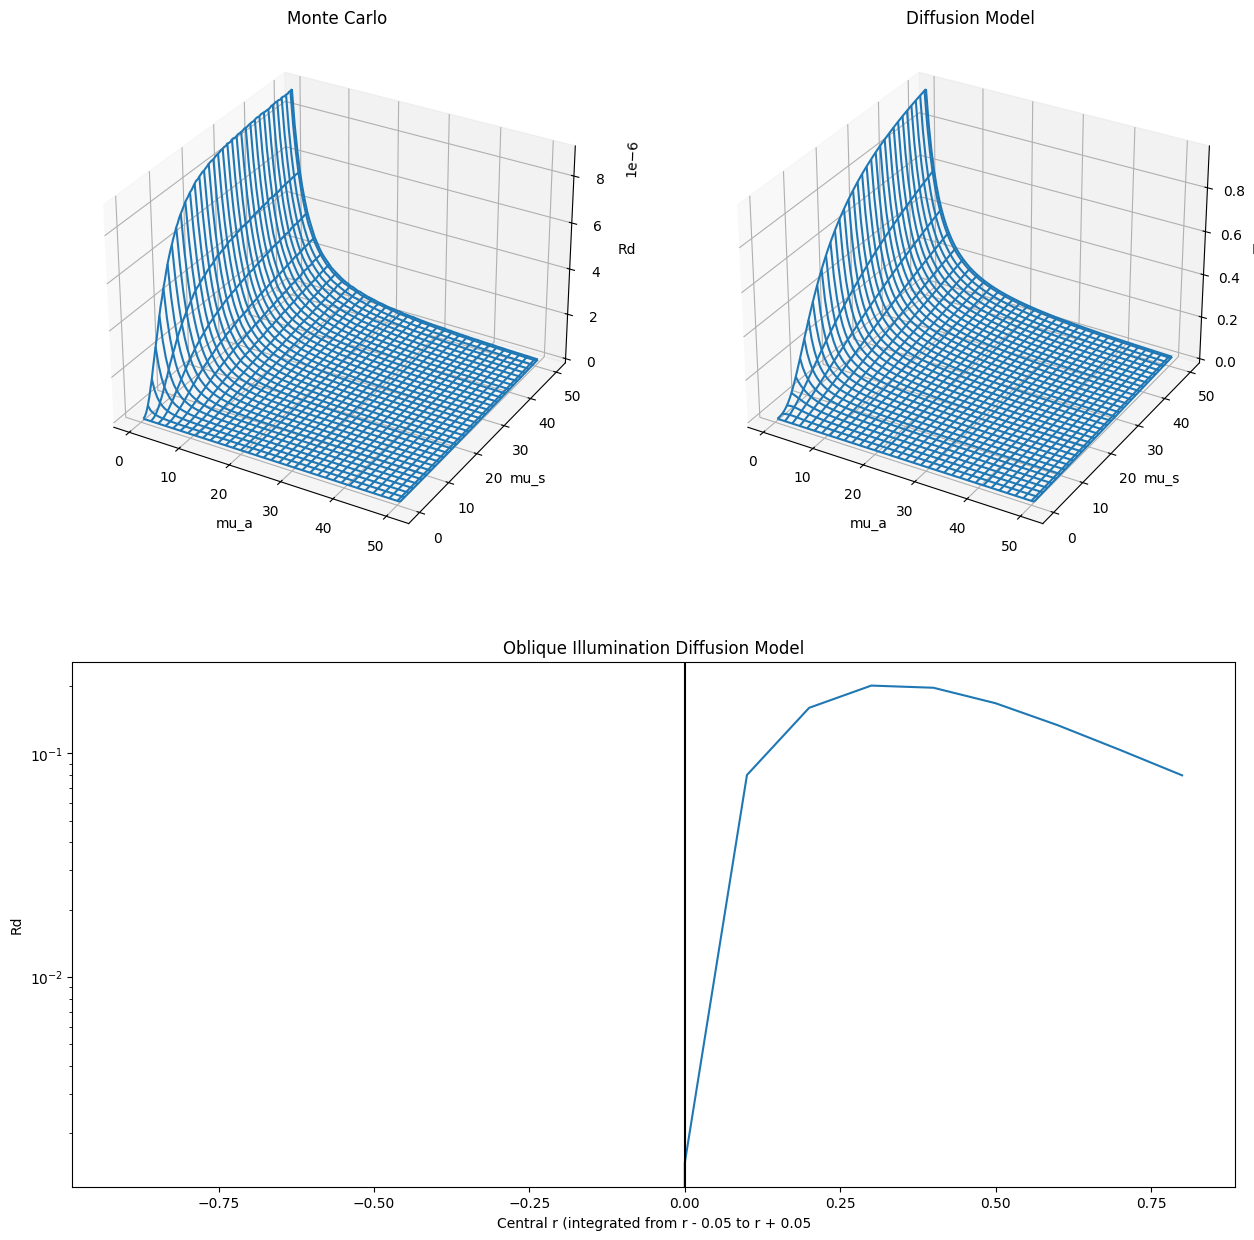

In [28]:
lut = LUT(dimensions=['mu_s', 'mu_a'], simulation_id=88, scale=50000)
X, Y, Z = lut.surface()
fig = plt.figure(figsize=[15, 15])
ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.plot_wireframe(Y, X, Z / 50000)
ax.set_title('Monte Carlo')
ax.set_xlabel('mu_a')
ax.set_ylabel('mu_s')
ax.set_zlabel('Rd')

theta = np.radians(60)
diffusion_model = create_integrated_diffusion_approximation((-0.9, 0.9), theta, 1.33, 0.9)
Rd = []
mu_eff = []
for mus, mua in itertools.product(np.unique(X), np.unique(Y)):
    Rd.append(diffusion_model(mus, mua))
Rd = np.asarray(Rd).reshape(len(X), len(Y))
ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.plot_wireframe(Y, X, Rd)
ax.set_title('Diffusion Model')
ax.set_xlabel('mu_a')
ax.set_ylabel('mu_s')
ax.set_zlabel('Rd')

Rd = []
ax = fig.add_subplot(2, 1, 2)
r_range = np.arange(-0.9, 0.9, 0.1)

for r in r_range:
    diffusion_model = create_integrated_diffusion_approximation((r - 0.05, r + 0.05), theta, 1.33, 0.9)
    Rd.append(diffusion_model(20, 0.25))
ax.plot(r_range, Rd)
ax.axvline(0, color='k')
ax.semilogy()
ax.set_xlabel('Central r (integrated from r - 0.05 to r + 0.05')
ax.set_ylabel('Rd')
ax.set_title('Oblique Illumination Diffusion Model')

plt.show()